This example computes the annual cycle for daily 700 hPa geopotential height anomalies (20N-90N) calculated by removing the annual mean using the first two harmonics. This script calculates the first 5 EOFS, the first 5 PCs and evaluates the eigenvectors. 

Import Python Libraries

In [1]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
import scipy.io as sio
import xarray as xr
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                 # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'                          # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'                        # figures

# # check that path exists
# path_to_figs.exists()

### Prepare Data

Read the data.

In [3]:
## Set variable names (for saving data/figs)
var_names = 'H700'

## Select lat/lon grid 
lonmin = -180
lonmax = 180
latmin = 20
latmax =  90

### MERRA2 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# open H data
filepath_pattern = path_to_data + 'MERRA2/anomalies/H700/daily_*.nc'

anomalies = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(anomalies.nbytes / 1e9))
anomalies

ds size in GB 9.02



<xarray.Dataset>
Dimensions:    (lat: 141, lon: 576, time: 13880)
Coordinates:
    lev        float64 700.0
  * lat        (lat) float64 20.0 20.5 21.0 21.5 22.0 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time       (time) datetime64[ns] 1980-01-01T09:00:00 ... 2017-12-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(366,), meta=np.ndarray>
Data variables:
    H          (time, lat, lon) float64 dask.array<chunksize=(366, 141, 576), meta=np.ndarray>

### Data subset selection

In [4]:
# Trim date range
start_date = '1980-12-01'
end_date = '2017-02-28'
idx = slice(start_date, end_date)
merra = anomalies.sel(time=idx)

# Select DJF months
idx = (merra.time.dt.month >= 12) | (merra.time.dt.month <= 2)
anomalies = merra.sel(time=idx)

# print results
print(anomalies)

<xarray.Dataset>
Dimensions:    (lat: 141, lon: 576, time: 3339)
Coordinates:
    lev        float64 700.0
  * lat        (lat) float64 20.0 20.5 21.0 21.5 22.0 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time       (time) datetime64[ns] 1980-12-01T09:00:00 ... 2017-02-28T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(31,), meta=np.ndarray>
Data variables:
    H          (time, lat, lon) float64 dask.array<chunksize=(31, 141, 576), meta=np.ndarray>


Remove the long-term mean in each gridpoint.

In [5]:
long_term_mean = anomalies.H.mean('time')
print(long_term_mean.shape)

sst = anomalies.H - long_term_mean

(141, 576)


Weight the SST anomaly value in each gridpoint by the square of the cosine of the latitude

In [6]:
# Weight the data set according to weighting argument.
coslat = np.cos(np.deg2rad(sst.coords['lat'].values))
wgts = np.sqrt(coslat)
wgts = xr.DataArray(wgts, coords=[sst.lat], dims=['lat'])
sst,weights = xr.broadcast(sst,wgts)
weighted_data = sst * weights
print(weighted_data.shape)

(3339, 141, 576)


Plot the standard deviation of the SST anomalies

In [8]:
weighted_data = weighted_data.load()

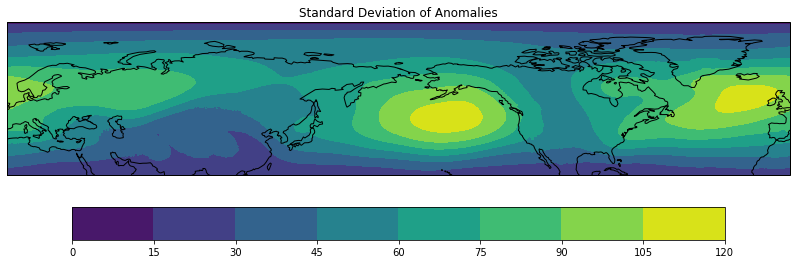

In [9]:
std_dev = np.std(weighted_data, axis=0)

plt.figure(figsize=[16., 4.])
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-179.5))
ax.set_extent([sst.lon.min(), sst.lon.max(), sst.lat.min(), sst.lat.max()], crs=ccrs.PlateCarree(central_longitude=-179.5))
cf = plt.contourf(sst.lon, sst.lat, std_dev, transform=ccrs.PlateCarree())
plt.title('Standard Deviation of Anomalies')
plt.colorbar(cf, orientation='horizontal')
ax.coastlines()
plt.show()

### EOF Analysis

Standardize the data by the columns

In [10]:
# x1std = np.std(weighted_data, axis=0)
## standardize data if using correlation matrix
x1std = std_dev
X1s = weighted_data / x1std

# ## if using covariance matrix
# X1s = weighted_data

# Flatten data into single array
[numtimes, numlats, numlons] = weighted_data.shape
## flatten lat and lon into 1 spatial location identifier
Xs = np.reshape(X1s.values, [numtimes, numlons*numlats])
Xs.shape

# Check that column means=0 and std dev=1
test = np.mean(np.mean(Xs, axis=0))
print("Column means: ", np.round(test,2))
test = np.mean(np.std(Xs, axis=0))
print("Column std: ", np.round(test,2))

Column means:  -0.0
Column std:  1.0


#### 1a. The data consist of 13880 points in time by 81216 points in space.

In [11]:
print(Xs.shape)

(3339, 81216)


In [12]:
# Find the indices of values that are missing in the whole row
nonMissingIndex = np.where(np.logical_not(np.isnan(Xs[0])))[0]
# Remove missing values from the design matrix.
dataNoMissing = Xs[:, nonMissingIndex]
print(dataNoMissing.shape)

(3339, 81216)


#### 1b.	Compute the covariance matrix of anomalies using the time dimension

In [13]:
print(len(nonMissingIndex))

81216


In [14]:
## Compute Covariance Matrix
A = np.dot(dataNoMissing, np.transpose(dataNoMissing))/(len(nonMissingIndex)-1.)
A.shape

(3339, 3339)

Text(0.5, 1.0, 'Correlation Matrix')

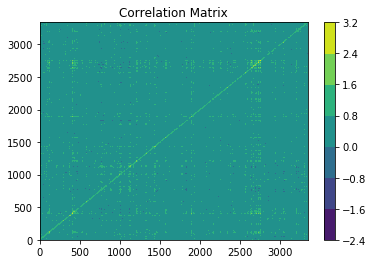

In [15]:
plt.contourf(A)
plt.colorbar()
plt.title('Correlation Matrix')

#### 1c. Compute the eigenvalues and eigenvectors of the covariance matrix.

In [16]:
## Compute the eigenvalues
eig, v = np.linalg.eig(A)
print('Eigenvalues shape: ', eig.shape)
print('Eigenvectors shape: ', v.shape)

Eigenvalues shape:  (3339,)
Eigenvectors shape:  (3339, 3339)


#### 1d. Plot the percentage of explained variance for eigenvalues 1-20.

Text(0, 0.5, 'Variance Explained (%)')

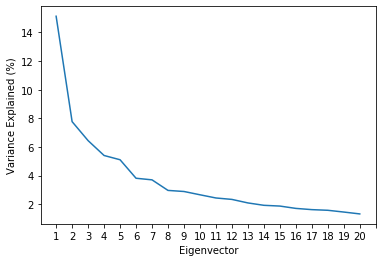

In [17]:
var_eig = eig/sum(eig)*100
var_eig[:20]
plt.plot(var_eig[:20])
plt.xticks(np.arange(0,21,1), labels=np.arange(1,21,1))
plt.xlabel('Eigenvector')
plt.ylabel('Variance Explained (%)')

#### 1e. Plot the EOF patterns and PCs for the first 5 modes. 

In [35]:
print(Xs.shape)
print(v[:, 0:neofs].T.shape)
print(v.shape)

(3339, 81216)
(4, 3339)
(3339, 3339)


In [36]:
# # project time EOF onto anomaly data
# neofs = 5
# flatE = np.ones([neofs, numlats*numlons], dtype=sst.dtype) * np.NaN
# for i in np.arange(neofs):
#     flatE[i,:] = np.matmul(v[:,i], Xs)
 
# print(flatE.shape)

# project time EOF onto anomaly data without loop
neofs = 5
flatE = np.matmul(v[:, 0:neofs].T, Xs)
 
print(flatE.shape)

(5, 81216)


In [37]:
rval = ma.array(flatE, mask=np.where(np.isnan(flatE), True, False))
print(rval.shape)
EOF_reshape = np.reshape(rval, [neofs, numlats, numlons])
print(EOF_reshape.shape)

(5, 81216)
(5, 141, 576)


In [38]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting
lons = anomalies.lon.data
lats = anomalies.lat.data

data = EOF_reshape[0:neofs,:,:]

print(np.nanmin(data), np.nanmax(data))

# Set up projection
# mapcrs = ccrs.PlateCarree()
mapcrs = ccrs.NorthPolarStereo(central_longitude=60.0)
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(var_eig[k]))

-36.066513706986704 52.33102353886718


/home/nash/DATA/repositories/AR_types/figs/EOF_AO_test.png


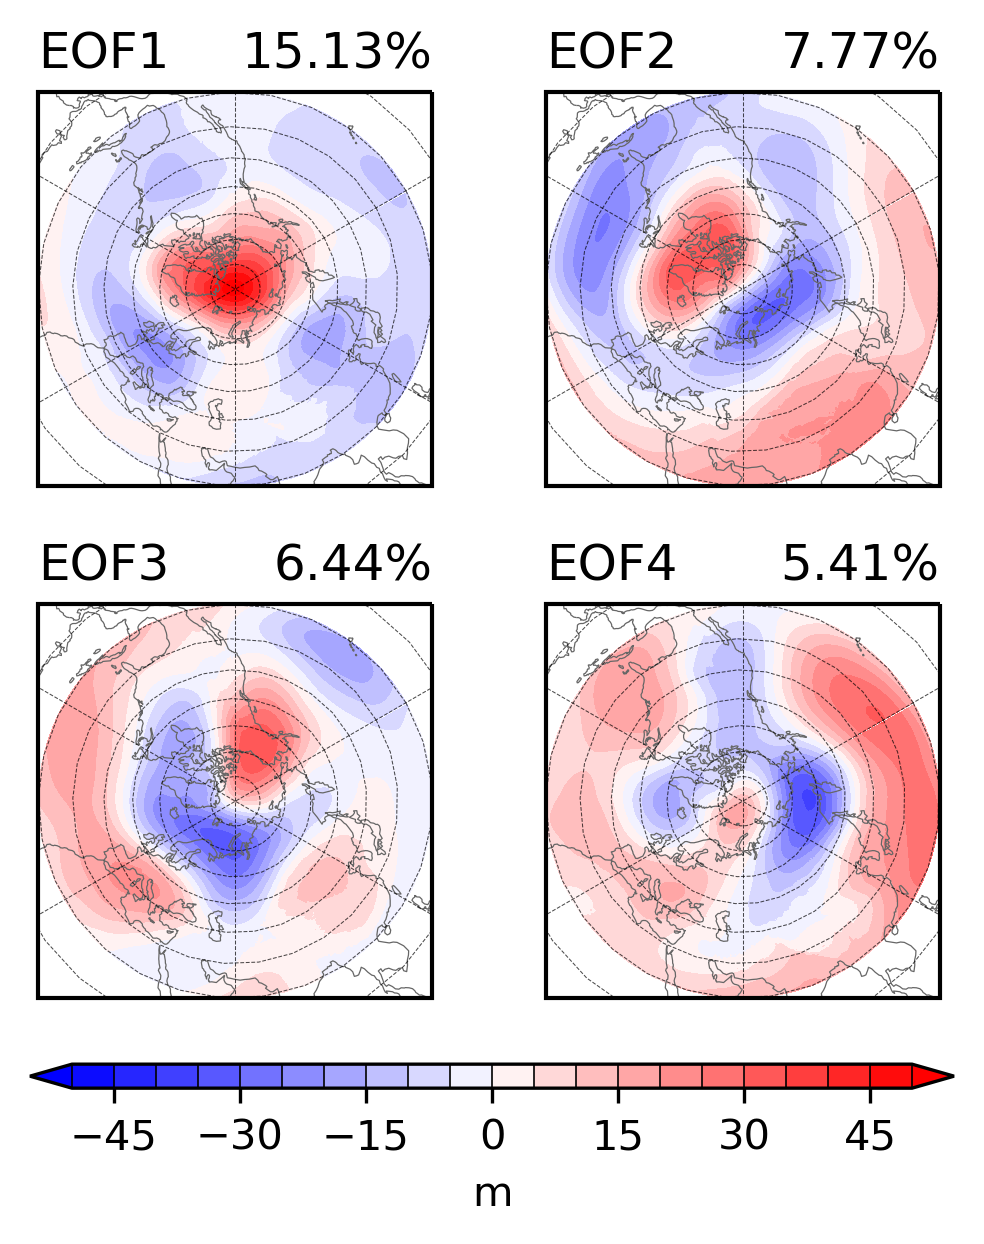

<Figure size 1200x1200 with 0 Axes>

In [39]:
fig = plt.figure(figsize=(4.0 ,4.0))
fig.dpi = 300
fname = path_to_figs + 'EOF_AO_test'
fmt = 'png'

for k in np.arange(len(data)):
    ax = plt.subplot(2, 2, k+1, projection=mapcrs)
#     ax.set_extent([lons.min(), lons.max(), lats.min(), 90.], crs=mapcrs)
    # Add contour fill plot
    clevs = np.arange(-50,55,5)
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
   
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
    ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.3)
#     ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.3)

    ## Add in meridian and parallels
    gl = ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--')

#     gl.xlocator = mticker.FixedLocator(np.arange(-180., 200., 20))
#     gl.ylocator = mticker.FixedLocator(np.arange(20., 70., 10.))
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
    
# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.13, 0.05, 0.77, 0.02])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='horizontal', extendfrac='auto')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('m', fontsize=10)

plt.subplots_adjust(hspace=0.3)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))
# plt.show()

/home/nash/DATA/repositories/AR_types/figs/PCA_AO.png


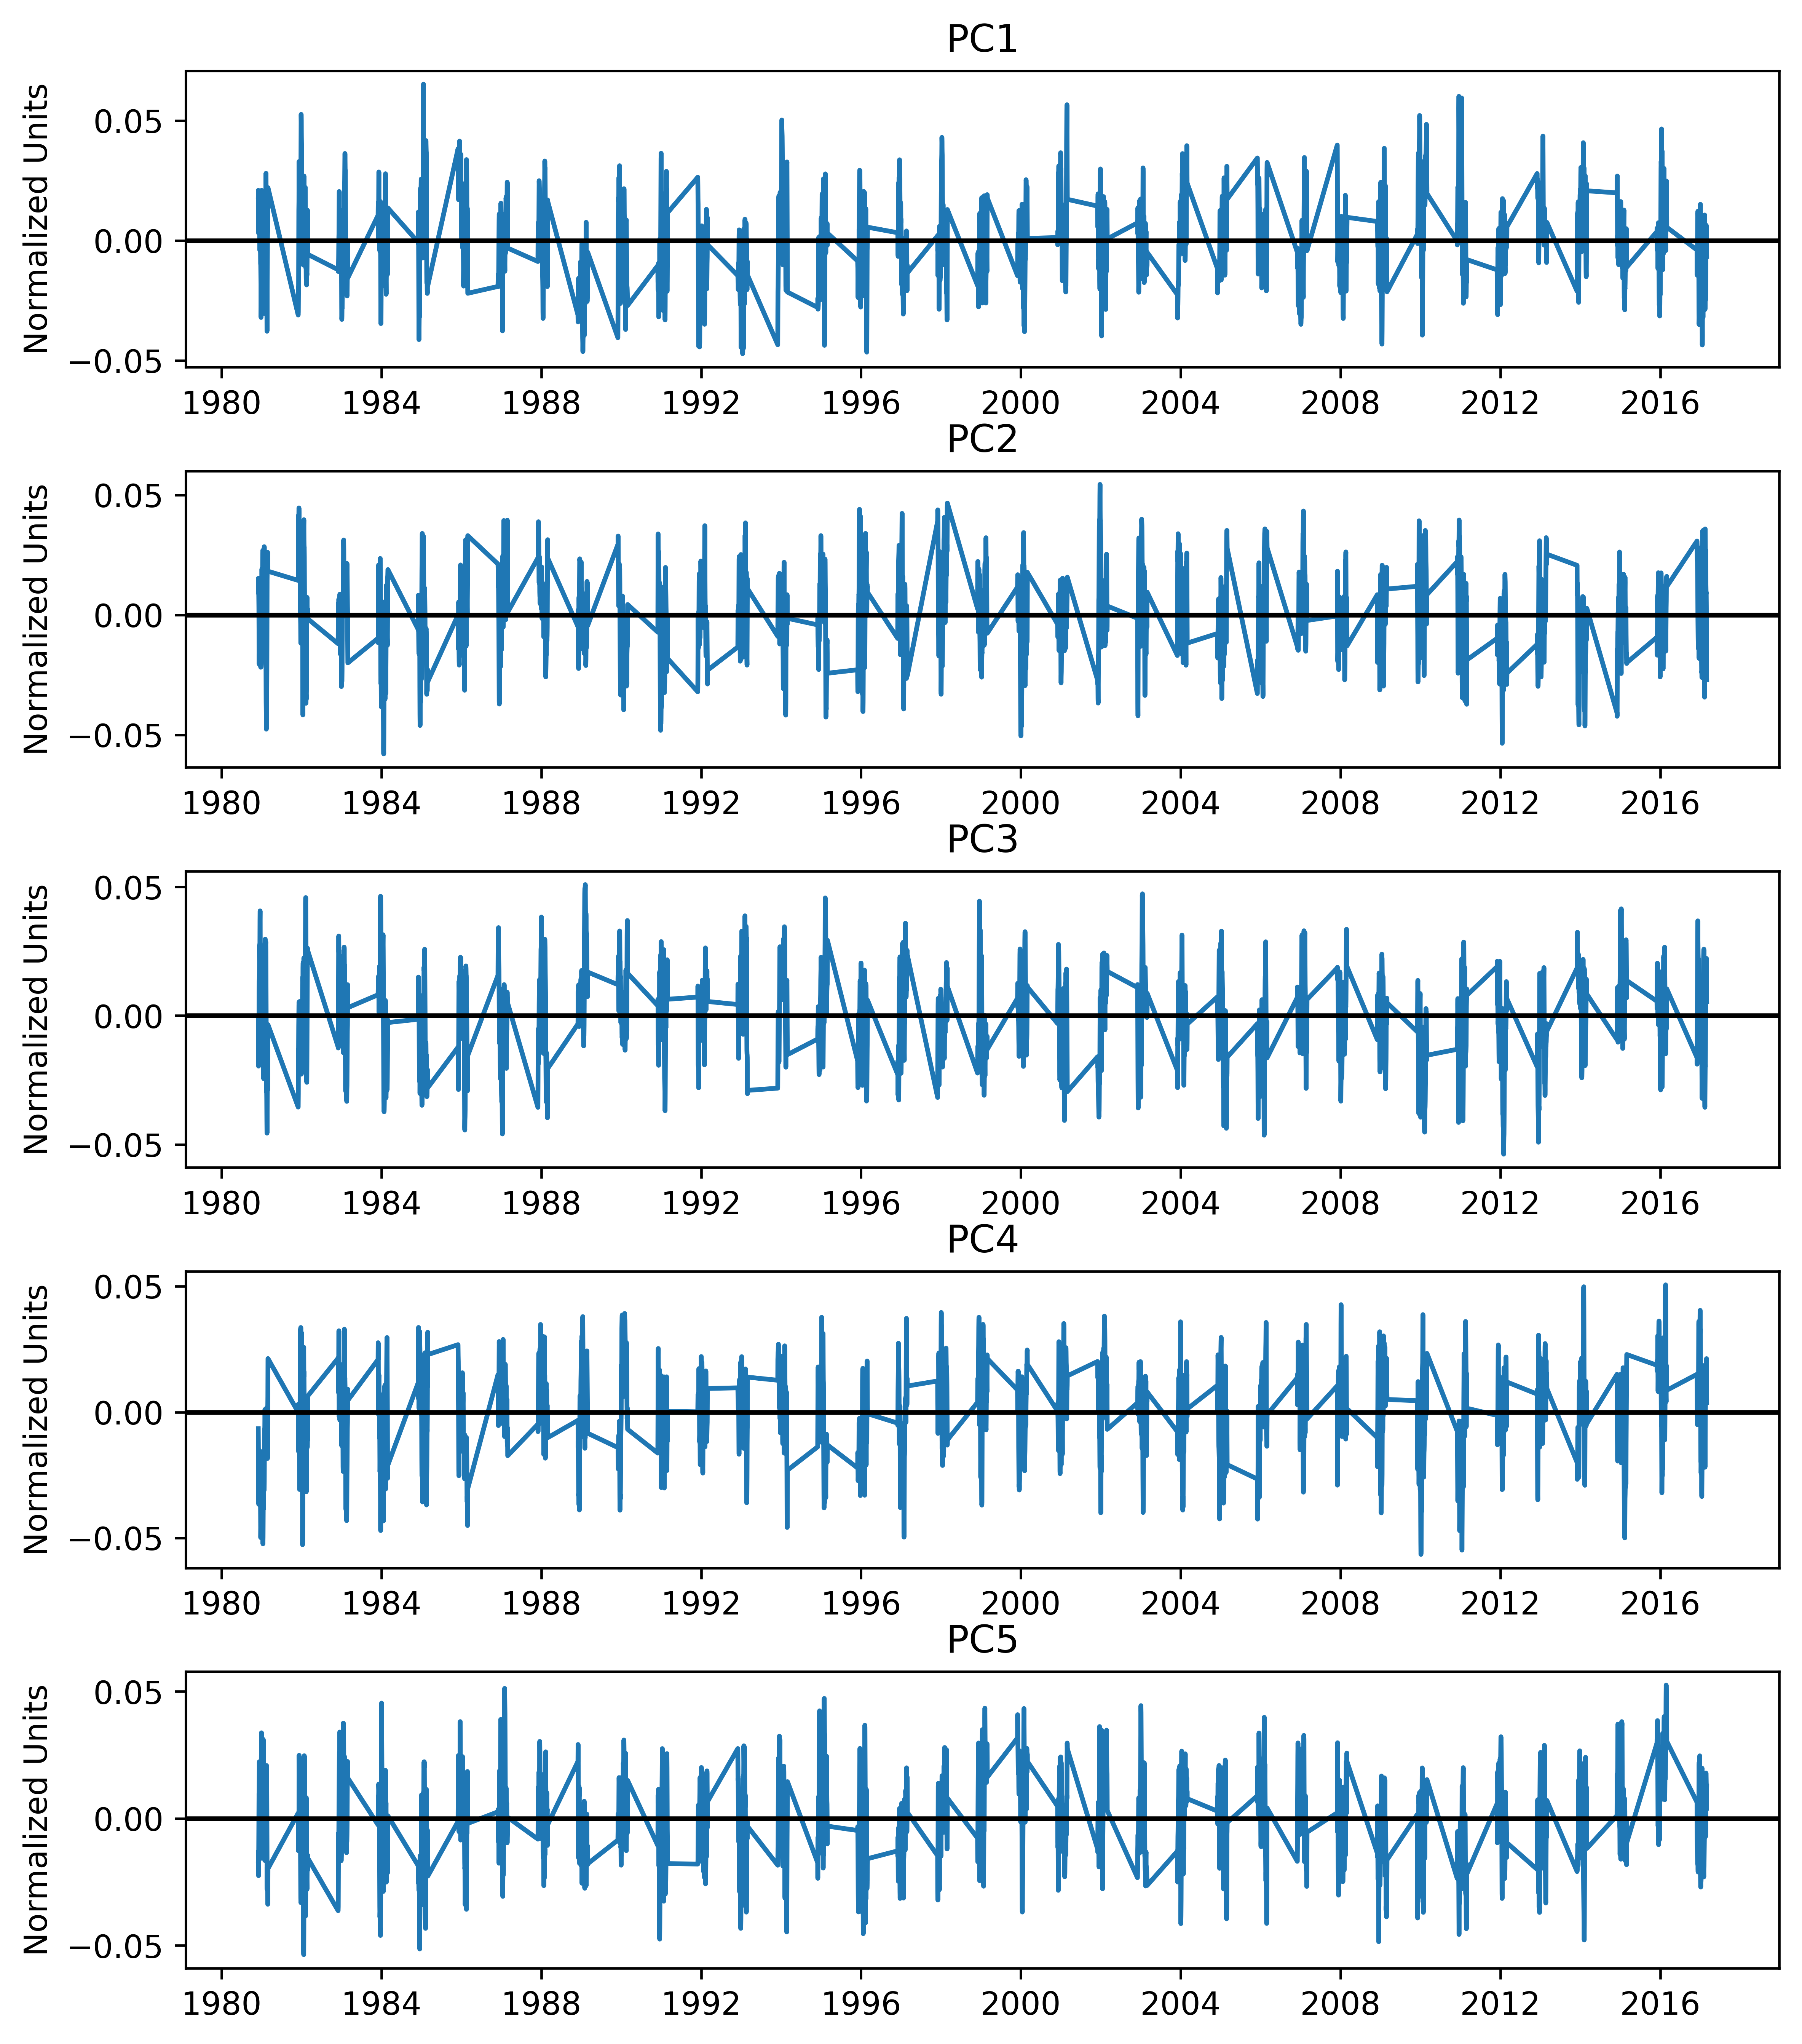

<Figure size 5400x6600 with 0 Axes>

In [25]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 600
fname = path_to_figs + 'PCA_AO'
fmt = 'png'
results = v[:,:5]
subtitles = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']

X, nplots = results.shape

for i in np.arange(nplots):
    ax = plt.subplot(5, 1, i+1)
    ax.plot_date(sst.time, results[:,i], '-')
    ax.axhline(0, color='k')
#     ax.set_ylim(-3, 3)
    ax.set_ylabel('Normalized Units')
    ax.set_title(subtitles[i], fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

/home/nash/DATA/repositories/AR_types/figs/EOF_AO.png


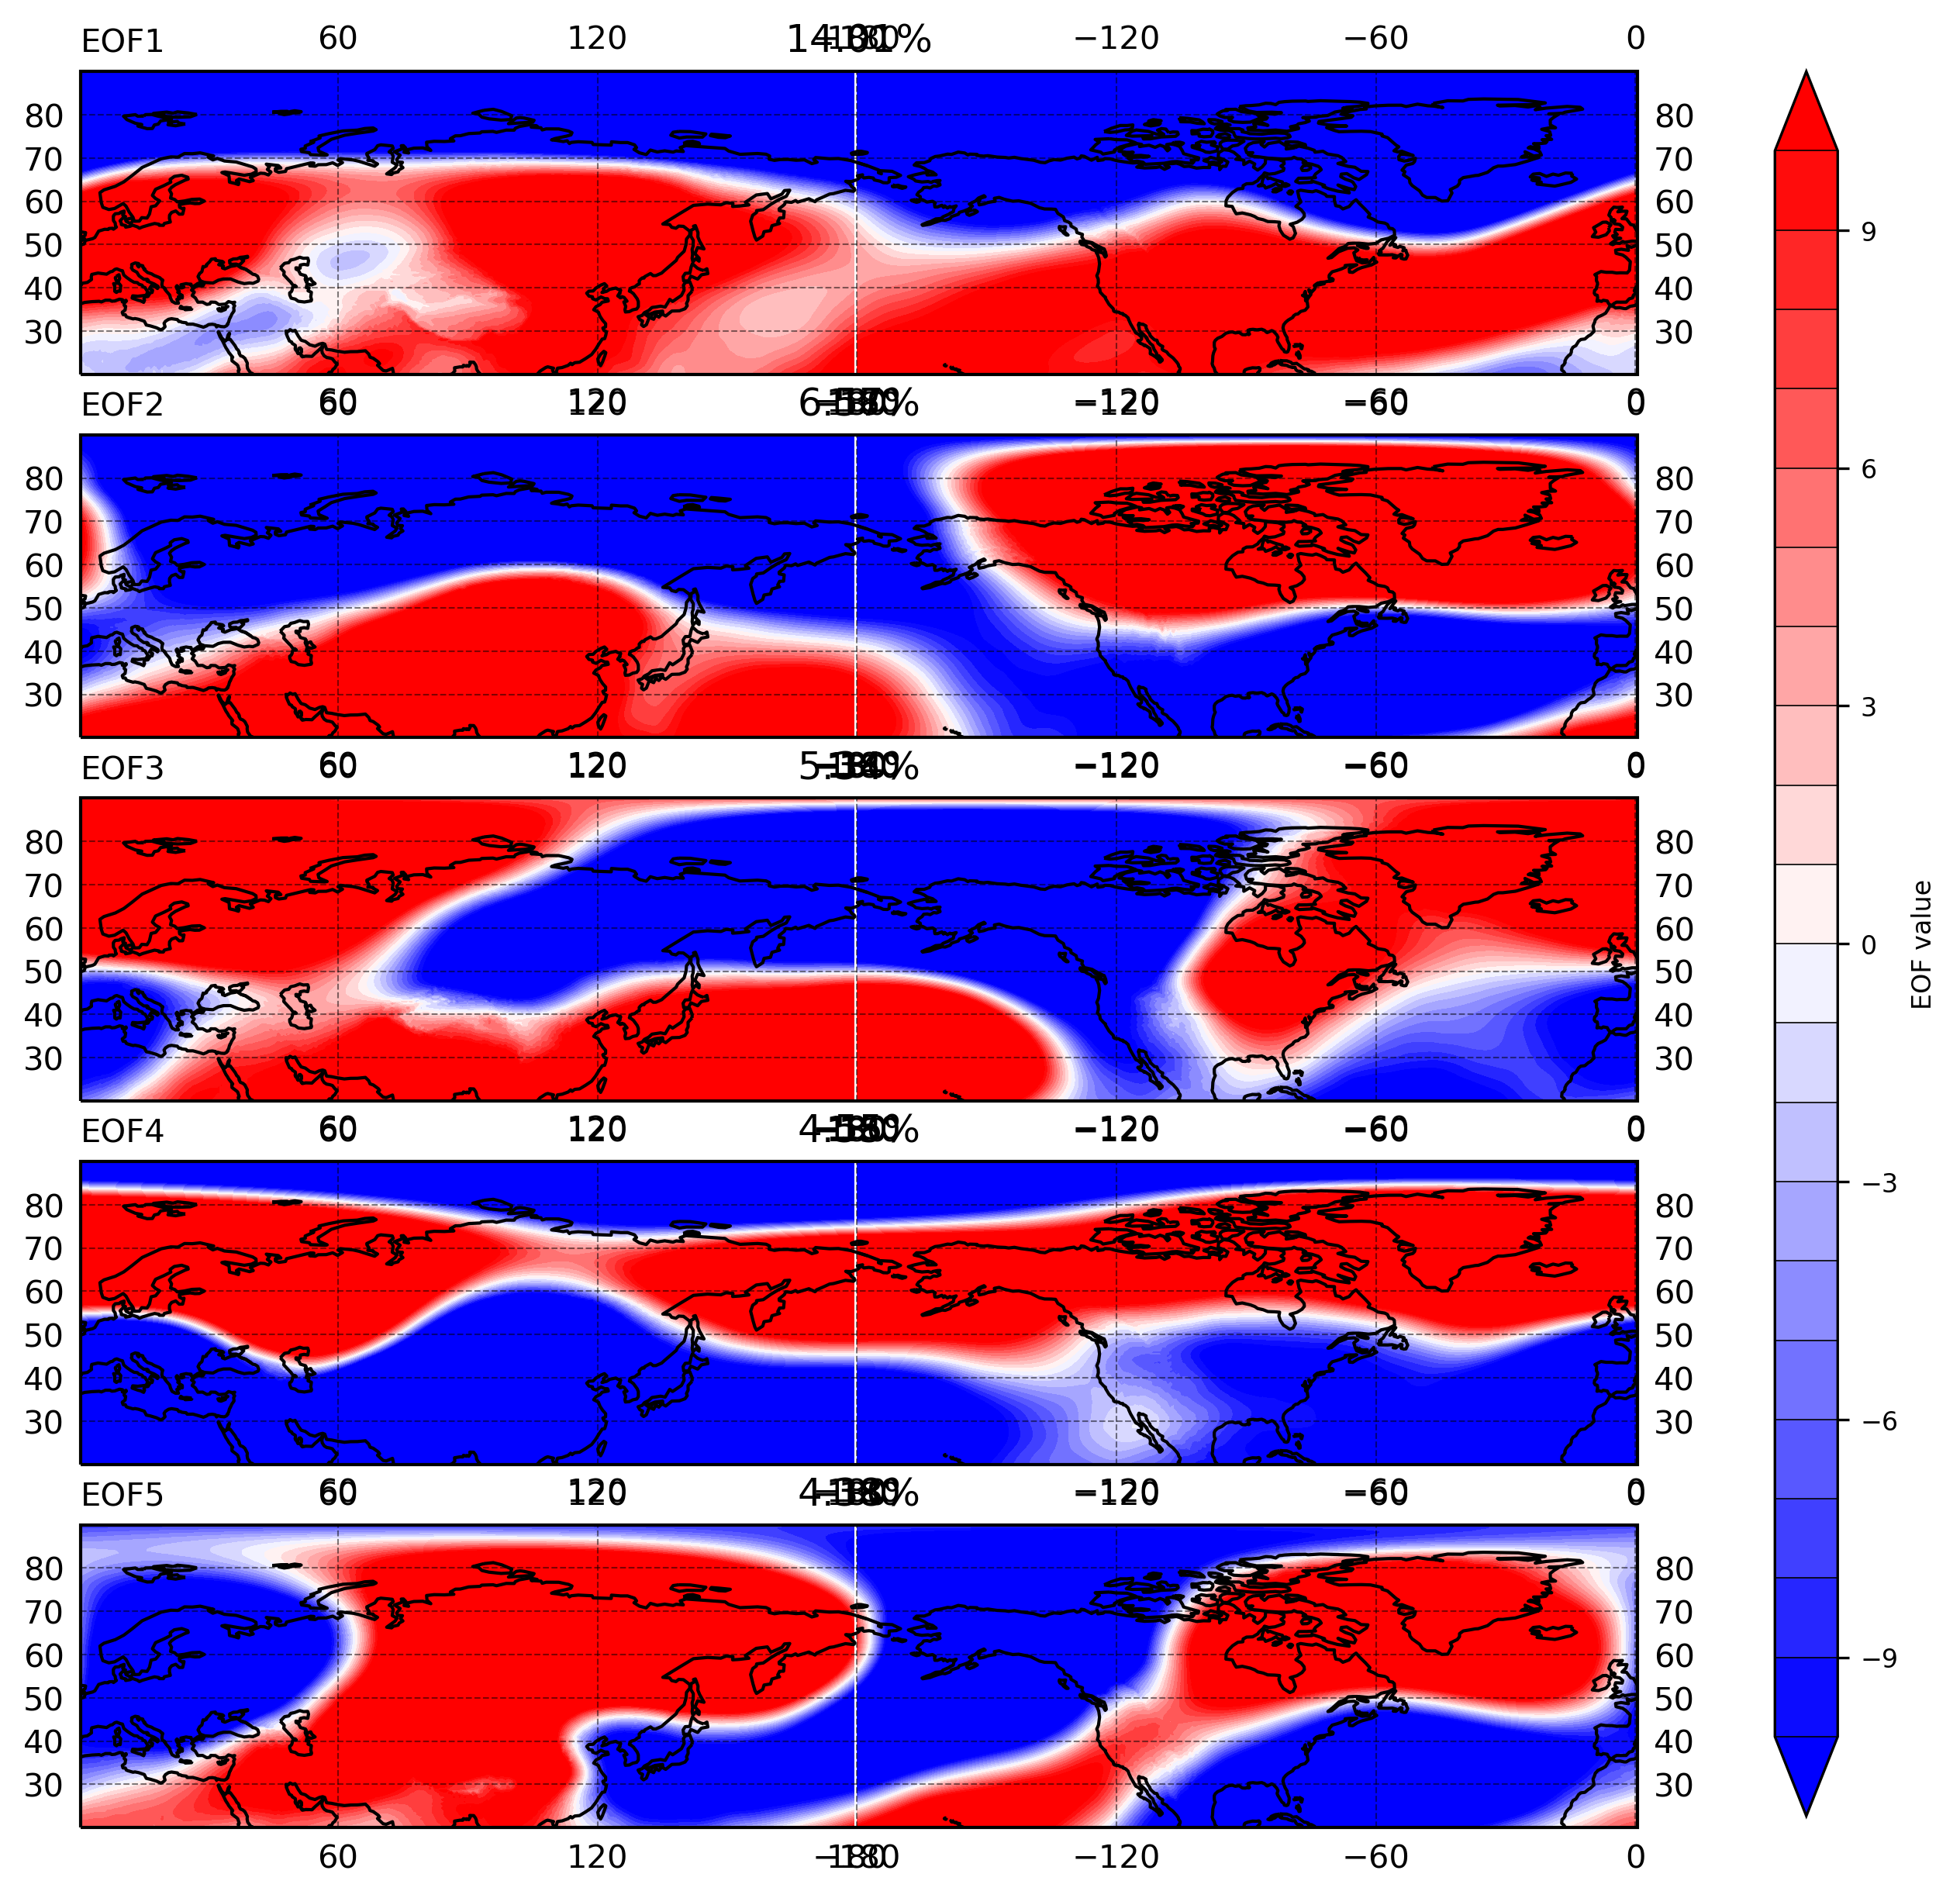

<Figure size 2700x3000 with 0 Axes>

In [22]:
fig = plt.figure(figsize=(9,10))
fig.dpi = 300
fname = path_to_figs + 'EOF_AO'
fmt = 'png'
results = EOF_reshape
subtitles = ['EOF1', 'EOF2', 'EOF3', 'EOF4', 'EOF5']

lats = sst['lat']
lons = sst['lon']

# clevs = np.arange(-0.025, 0.030, 0.005)
clevs = np.arange(-10, 11, 1)

for i in np.arange(len(results)):
    ax = plt.subplot(5, 1, i+1, projection=ccrs.PlateCarree(central_longitude=-179.5))
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree(central_longitude=-179.5))
    cf = ax.contourf(lons, lats, results[i], transform=ccrs.PlateCarree(),
                     extend='both', cmap='bwr', levels=clevs)
    ax.coastlines(linewidths=1.0)
    ax.set_title(subtitles[i], fontsize=10, loc='left')
    ax.set_title("{:.2f}%".format(var_eig[i], loc='right'))
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      linewidth=.5, color='black', alpha=0.5, linestyle='--')
#     gl.xlabels_top = False
#     gl.ylabels_right = False
#     gl.xlocator = mticker.FixedLocator(np.arange(-180, 200, 20))
#     gl.ylocator = mticker.FixedLocator(np.arange(-30, 40, 10))
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
#     gl.xlabel_style = {'size': 7}
#     gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.95, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label('EOF value', fontsize=8)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### EOF Separation

#### 2a. Using SST anomalies, compute the first auto-correlation for each gridpoint and obtain an average value. Estimate the effective sample size using:

$$ n' \equiv \frac{1 - \rho_{1}}{1 + \rho_{1}}$$

In [ ]:
numtimes, numlats, numlons = weighted_data.shape
X1 = np.reshape(weighted_data[:-1, :,:].values, [numtimes-1, numlats*numlons])
X2 = np.reshape(weighted_data[1:, :,:].values, [numtimes-1, numlats*numlons])
X1.shape

autocorr1 = []
for i in np.arange(numlats*numlons):
    autocorr1.append(np.corrcoef(X1[:,i], X2[:,i]))

In [ ]:
autocorr1_array = np.array(autocorr1)
autocorr1_mean = np.nanmean(autocorr1_array[:, 1, 0])

sample_size = numtimes*((1-autocorr1_mean)/(1+autocorr1_mean))
print(sample_size)

#### 2b. Use the North et al (1982) criteria to estimate the uncertainty in the eigenvalues estimation.

In [ ]:
factor = np.sqrt(2.0 / sample_size)
errors = eig[:20] * factor
errors

#### 2c. Plot eigenvalues 1-20 with the error bars calculated in item 2b above.

In [ ]:
eig[:20]

In [ ]:
plt.errorbar(x=np.arange(0,20,1), y=eig[:20], yerr=errors, fmt='o', capsize=5)
f = plt.xticks(np.arange(0,21,1), labels=np.arange(1,21,1))

 ### Questions

**1.	Why do you need to weight the SST values by the square of cosine of latitude?**

The data is in a regular latitude/longitude grid, and needs to be transformed into an equal-area grid. To accomplish this, each grid cell needs ot be weighted (i.e. multiply the time series at each grid box by the square root of the
cosine of latitude). This weighting function compensates for the decrease of the gridcell size in the higher latitude regions. If the gridcells are not area-weighted, it is possible that the EOFs can shift spatially, yielding different results. 

**2.	How many EOF modes are separated?**

The first three EOFs seem well separated from the rest of the EOFs, particularly when looking at the first 20 eigenvalues. 

**3.	Please give an interpretation for EOFs 1-5.**

EOF 1 is showing a consistent positive loading across the spatial area. It is possible that it is not showing much of a spatial pattern because it is reflecting the overall warming trend of SST, which was not removed from the dataset. The first PC is showing a positive trend, particularly after 1960. EOF 2 is showing a loading pattern similar to that of ENSO, with a elongated zone of positive loading in the equatorial Pacific and strong, negative loading in all other ocean basins. The second PC is showing almost an opposite trend of the first PC, with decreasing values post-1960. The third EOF is showing another familiar ENSO pattern, with positive loading in the east equatorial pacific, and a sideways v shaped negative loading around the zone of positive loading in the Pacific. PC 3 is showing a pattern of decreasing values for about 20 years, then a sharp incline, particularly after 1960. EOF 4 has two areas of strong negative loading - one in the northern Pacific, and one in the southeast Atlantic. The fifth EOF has positive loading patterns near the west coast of South America, as well as in the central Atlantic. South Atlantic is showing a region of strong negative loading, similar to that of EOF4.  
